# Machine learning experiment 2-1 -- Logistic Regression

In [1]:
# setup code

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 8.0) # set default size of plots

%load_ext autoreload
%autoreload 2

# Data Loading and Preprocessing

In [2]:
# Load the raw housing_scale data.
filename_train = '../dataset/a9a'
filename_test = '../dataset/a9a.t'
X_train, y_train = load_svmlight_file(filename_train, n_features = 123)
X_test, y_test = load_svmlight_file(filename_test, n_features = 123)
X_train, X_test = X_train.toarray(), X_test.toarray()

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (32561, 123)
Train labels shape:  (32561,)
Test data shape:  (16281, 123)
Test labels shape:  (16281,)


In [3]:
# preprocessing: substract the mean of each feature
# first: compute the mean of the features of train data

_mean = np.mean(X_train, axis = 0)
# print(_mean)

In [4]:
# second: subtract the mean from train and test data
X_train -= _mean
X_test -= _mean

In [5]:
# third: append the bias dimension of ones
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print(X_train.shape, X_test.shape)

(32561, 124) (16281, 124)


# Helper Function

In [6]:
def compute_accuracy(y_pred, y_grondtrue):
    return np.mean(np.array(y_pred == y_grondtrue), dtype = np.float32)

def sigmoid(x):
    return 1 / (1 + np.exp(- x))

# Optimizer

In [7]:
class GradientDescent(object):

    def __init__(self, learning_rate = 0.01):
        self.learning_rate = learning_rate
        
    def update(self, W, grad):
        return W - self.learning_rate * grad

In [8]:
class NAG(object):

    def __init__(self, learning_rate = 0.01, mu = 0.9):
        self.v = None
        self.learning_rate = learning_rate
        self.mu = mu
        
    def update(self, W, grad):
        if self.v is None:
            self.v = np.zeros(W.shape)
        v_prev = self.v
        self.v = self.mu * self.v + self.learning_rate * grad
        W -= self.mu * v_prev + (1 + self.mu) * self.v
        return W

In [9]:
class RMSProp(object):

    def __init__(self, learning_rate = 0.01, decay_rate = 0.9):
        self.cache = None
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
    
    def update(self, W, grad):
        if self.cache is None:
            self.cache = np.zeros(W.shape)
        self.cache = self.decay_rate * self.cache + (1 - self.decay_rate) * np.square(grad)
        W -= self.learning_rate * grad / (np.sqrt(self.cache) + 1e-5)
        return W

In [10]:
class AdaDelta(object):
    
    def __init__(self, decay_rate = 0.9):
        self.accumulate_grad = None
        self.accumulate_update = None
        self.decay_rate = decay_rate
    
    def update(self, W, grad):
        if self.accumulate_grad is None:
            self.accumulate_grad = np.zeros(W.shape)
            self.accumulate_update = np.zeros(W.shape)
        self.accumulate_grad = self.decay_rate * self.accumulate_grad \
                                + (1 - self.decay_rate) * np.square(grad)
        delta = - (np.sqrt(self.accumulate_update + 1e-5) / np.sqrt(self.accumulate_grad + 1e-5)) * grad
        W += delta
        self.accumulate_update = self.decay_rate * self.accumulate_update \
                                + (1 - self.decay_rate) * np.square(delta)
        return W

In [11]:
class Adam(object):

    def __init__(self, beta1=0.9, beta2=0.999, learning_rate=0.005, epsilon=1e-8):
        self.m = None
        self.v = None
        self.beta1 = beta1
        self.beta2 = beta2
        self.learning_rate = learning_rate
        self.epsilon = epsilon
    
    def update(self, W, grad, it):
        '''
        Inputs:
        - it: # iteration. use in the bias correction mechanism to warm up at the first few steps
        '''
        it += 1
        if self.m is None:
            self.m = np.zeros(W.shape)
            self.v = np.zeros(W.shape)
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad
        self.v = self.beta2 * self.v + (1 - self.beta2) * np.square(grad)
        mt = self.m / (1 - self.beta1 ** it)
        vt = self.v / (1 - self.beta2 ** it)
        W -= self.learning_rate * mt / (np.sqrt(vt) + self.epsilon)
        return W

# Logistic Regression

In [12]:
class LogisticRegressionModel(object):
    
    def __init__(self):
        self.W = None
    
    def train(self, X, y, optimizer=GradientDescent, regularization_strength=1.0, num_iters=100, 
             batch_size=None, verbose=False):
        '''
        Train this logistic regresser using optimizer provided.
        
        Inputs:
        - X: A numpy array of shape (N, D) containing training data;
             there are N training samples each of dimension D.
        - y: A numpy array of shape (N,) comtaining training labels.
        - optimizer: the algrithm used to train the model (update the para self.W).
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing.
        - batch_size: (interger) number of training examples to use at each;
                      if not provided (batch_size == None), using normal GD (without stochastic)
        - verbose: (boolean) if true, print progress during optimization.
        '''
        num_train, dim = X.shape
        if self.W is None:
            self.W = 0.001 * np.random.random((dim, 1))
        
        loss_history = []
        for it in range(num_iters):
            X_batch, y_batch = None, None
            if batch_size is None:
                X_batch, y_batch = X, y
            else:
                sample_index = np.random.choice(num_train, batch_size, replace = True)
                X_batch, y_batch = X[sample_index], y[sample_index]
            
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)
            
            # update the W use the optimizer
            self._update_parameter(optimizer, grad, it)
            
            if verbose and it % 10 == 0:
                print('iteration %d / %d: loss: %f' % (it, num_iters, loss))
        
        return loss_history
    
    def predict(self, X):
        '''
        Use the trained weights of the logistic regresser to predict labels for data points.
        
        Inputs:
        - X: A numpy array of shape (N, D) containing data;
             there are N training samples each of dimension D.
        
        Returns:
        - y_pred: A numpy array of shape (N,) comtaining predicted labels for the data in X.
        '''
        scores = X.dot(self.W) # (N,)
        y_pred = - np.ones(scores.shape)
        y_pred[(scores>=0.0).reshape(-1)] = 1
        
        return y_pred.reshape(-1)
    
    def loss(self, X_batch, y_batch, regularization_strength=1.0):
        '''
        Compute the loss function and its gradient
        
        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N data points;
                    each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.
        
        Returns: A tuple containing:
        - loss as a single float
        - gradient w.r.t. self.W (an array of the same shape as W)
        '''
 
        num_train, dim = X_batch.shape
        
        if self.W is None:
            self.W = 0.001 * np.random.random((dim, 1))
  
        scores = X_batch.dot(self.W) # (N, 1)
        sigmoid_act = sigmoid(y_batch.reshape(-1, 1) * scores) # (N, 1)
        
        loss = - np.mean(np.log(sigmoid_act)) + reg * 0.5 * np.sum(np.square(self.W ))
        grad = np.mean((- X_batch * y_batch.reshape(-1, 1)) / (1 + np.exp(y_batch.reshape(-1, 1) * scores)), 
                       axis = 0).reshape(-1, 1) + reg * self.W  # (D, 1)
        
        return loss, grad
    
    def _update_parameter(self, optimizer, grad, it):
        '''
        helper function: use optimizer to update parameter
        '''
        if isinstance(optimizer, GradientDescent):
            self.W = optimizer.update(self.W, grad)
        elif isinstance(optimizer, NAG):
            self.W = optimizer.update(self.W, grad)
        elif isinstance(optimizer, RMSProp):
            self.W = optimizer.update(self.W, grad)
        elif isinstance(optimizer, AdaDelta):
            self.W = optimizer.update(self.W, grad)
        elif isinstance(optimizer, Adam):
            self.W = optimizer.update(self.W, grad, it)

# Gradient Descent vs. Stochastic Gradient Descent

In [13]:
import time
reg = 1.0
num_iters = 1200
gd = GradientDescent(learning_rate=0.001)


################  Gradient Descent  ################
model_gd = LogisticRegressionModel()

tic = time.time()
loss_history_gd = model_gd.train(X_train, y_train, optimizer=gd, regularization_strength=reg, 
                           num_iters=num_iters, batch_size=None, verbose=False)
toc = time.time()
time_cost_gd = toc - tic
####################################################


################ Stochastic Gradient Descent ################
batch_size = 256
model_sgd = LogisticRegressionModel()
tic = time.time()
loss_history_sgd = model_sgd.train(X_train, y_train, optimizer=gd, regularization_strength=reg, 
                           num_iters=num_iters, batch_size=batch_size, verbose=False)
toc = time.time()
time_cost_sgd = toc - tic
#############################################################


loss_train_gd, _ = model_gd.loss(X_batch=X_train, y_batch=y_train, regularization_strength=reg)
loss_test_gd, _ = model_gd.loss(X_test, y_test, regularization_strength=reg)
accuracy_train_gd = compute_accuracy(model_gd.predict(X_train), y_train)
accuracy_test_gd = compute_accuracy(model_gd.predict(X_test), y_test)

loss_train_sgd, _ = model_sgd.loss(X_batch=X_train, y_batch=y_train, regularization_strength=reg)
loss_test_sgd, _ = model_sgd.loss(X_test, y_test, regularization_strength=reg)
accuracy_train_sgd = compute_accuracy(model_sgd.predict(X_train), y_train)
accuracy_test_sgd = compute_accuracy(model_sgd.predict(X_test), y_test)

print('Run Gradient Descent for %d times:' %num_iters)
print('time cost: %.5fs' % time_cost_gd)
print('train loss: %.5f' % loss_train_gd)
print('test loss: %.5f' % loss_test_gd)
print('train accuarcy: %.5f' % accuracy_train_gd)
print('test accuarcy: %.5f' % accuracy_test_gd)

print('\n\nRun Stochastic Gradient Descent (batch size = %d) for %d times:' % (batch_size, num_iters))
print('time cost: %.5fs' % time_cost_sgd)
print('train loss: %.5f' % loss_train_sgd)
print('test loss: %.5f' % loss_test_sgd)
print('train accuarcy: %.5f' % accuracy_train_sgd)
print('test accuarcy: %.5f' % accuracy_test_sgd)

Run Gradient Descent for 1200 times:
time cost: 44.45148s
train loss: 0.64962
test loss: 0.64896
train accuarcy: 0.82040
test accuarcy: 0.82219


Run Stochastic Gradient Descent (batch size = 256) for 1200 times:
time cost: 1.24606s
train loss: 0.64961
test loss: 0.64895
train accuarcy: 0.81975
test accuarcy: 0.82151


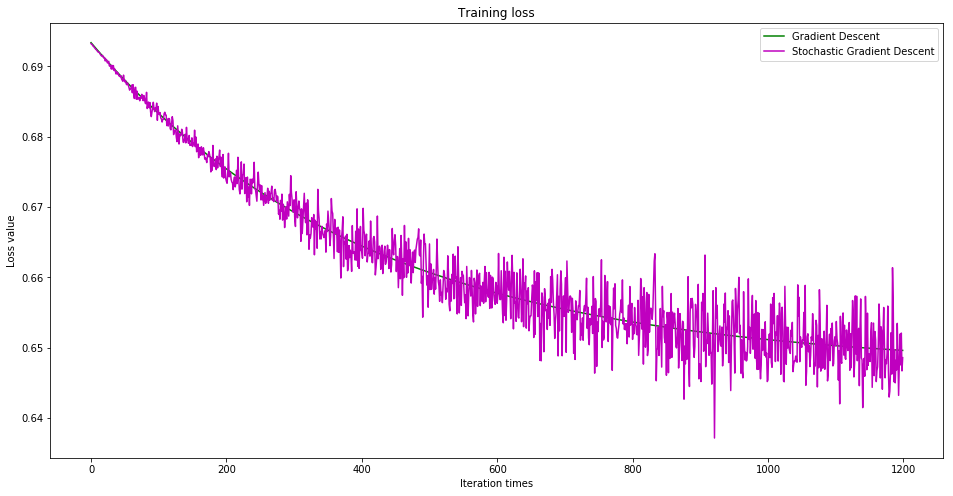

In [14]:
plt.title('Training loss')
plt.plot(loss_history_gd, 'g', label='Gradient Descent')
plt.plot(loss_history_sgd, 'm', label='Stochastic Gradient Descent')
plt.xlabel('Iteration times')
plt.ylabel('Loss value')
plt.legend()
plt.show()

# Contrast vanilla Gradient Descent with advanced optimized methods

In [15]:
reg = 0.5
num_iters = 150
batch_size = 4096
################  NAG  ################
nag = NAG(learning_rate=0.001, mu=0.9)
model_nag = LogisticRegressionModel()
loss_history_nag = model_nag.train(X_train, y_train, nag, reg, num_iters, batch_size, False)

################  RMSprop  ################
rmsprop = RMSProp(learning_rate=0.005, decay_rate=0.9)
model_rmsprop = LogisticRegressionModel()
loss_history_rmsprop = model_rmsprop.train(X_train, y_train, rmsprop, reg, num_iters, batch_size, False)

################  AdaDelta  ################
adadelta = AdaDelta(decay_rate=0.95)
model_adadelta = LogisticRegressionModel()
loss_history_adadelta = model_adadelta.train(X_train, y_train, adadelta, reg, num_iters, batch_size, False)

################  Adam  ################
adam = Adam(beta1=0.9, beta2=0.999, learning_rate=0.01)
model_adam = LogisticRegressionModel()
loss_history_adam = model_adam.train(X_train, y_train, adam, reg, num_iters, batch_size, False)


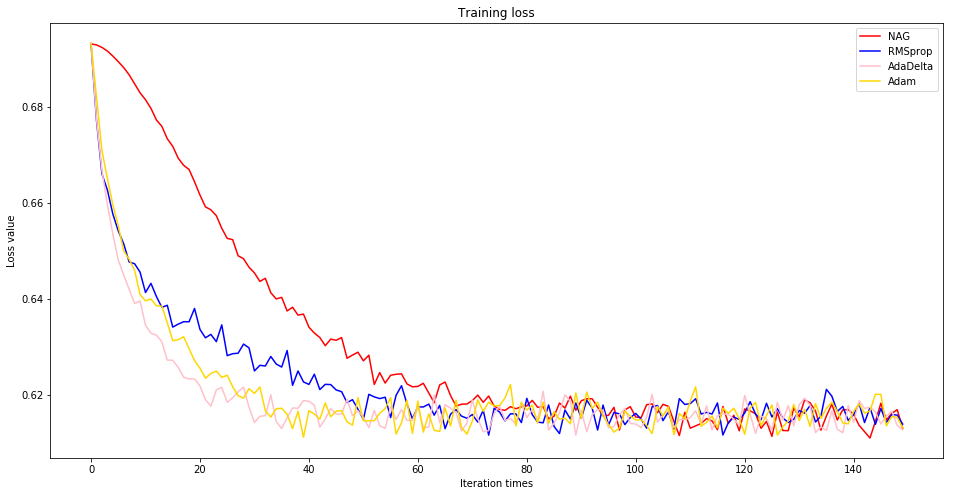

In [16]:
plt.title('Training loss')
plt.plot(loss_history_nag, 'r', label='NAG')
plt.plot(loss_history_rmsprop, 'b', label='RMSprop')
plt.plot(loss_history_adadelta, 'pink', label='AdaDelta')
plt.plot(loss_history_adam, 'gold', label='Adam')
plt.xlabel('Iteration times')
plt.ylabel('Loss value')
plt.legend()
plt.show()

# Train Model with Adam

In [17]:
reg = 0
num_iters = 250
batch_size = 4096

adam = Adam(beta1=0.9, beta2=0.999, learning_rate=0.01)
model_adam = LogisticRegressionModel()
loss_history = model_adam.train(X_train, y_train, adam, reg, num_iters, batch_size, True)
accuracy_train = compute_accuracy(model_adam.predict(X_train), y_train)
accuracy_test = compute_accuracy(model_adam.predict(X_test), y_test)

print('\n\ntrain accuarcy: %.5f' % accuracy_train)
print('test accuarcy: %.5f' % accuracy_test)

iteration 0 / 250: loss: 0.693329
iteration 10 / 250: loss: 0.579424
iteration 20 / 250: loss: 0.513339
iteration 30 / 250: loss: 0.482575
iteration 40 / 250: loss: 0.468545
iteration 50 / 250: loss: 0.439481
iteration 60 / 250: loss: 0.420576
iteration 70 / 250: loss: 0.404502
iteration 80 / 250: loss: 0.400311
iteration 90 / 250: loss: 0.387575
iteration 100 / 250: loss: 0.383507
iteration 110 / 250: loss: 0.375327
iteration 120 / 250: loss: 0.359793
iteration 130 / 250: loss: 0.362167
iteration 140 / 250: loss: 0.352567
iteration 150 / 250: loss: 0.357757
iteration 160 / 250: loss: 0.354808
iteration 170 / 250: loss: 0.349729
iteration 180 / 250: loss: 0.348939
iteration 190 / 250: loss: 0.341635
iteration 200 / 250: loss: 0.336594
iteration 210 / 250: loss: 0.341200
iteration 220 / 250: loss: 0.332803
iteration 230 / 250: loss: 0.342039
iteration 240 / 250: loss: 0.332809


train accuarcy: 0.84865
test accuarcy: 0.84804


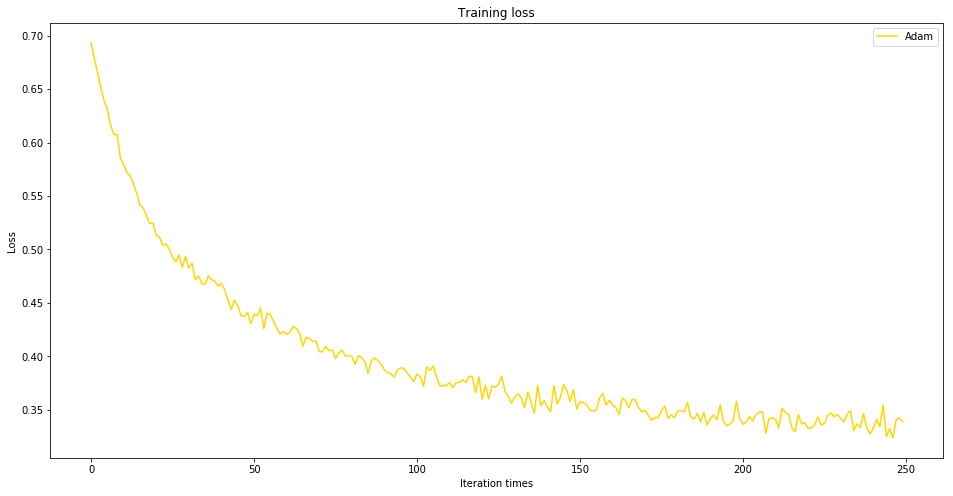

In [18]:
plt.title('Training loss')
plt.plot(loss_history, 'gold', label='Adam')
plt.xlabel('Iteration times')
plt.ylabel('Loss')
plt.legend()
plt.show()